# Test

> Test Fast.ai install

In [6]:
#| default_exp core

In [7]:
#| hide
from nbdev.showdoc import *

%matplotlib inline
from fastai.vision.all import *
from fastai.data.all import *
import torch.nn.functional as F

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

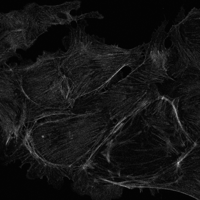

In [8]:
path = Path('../_data/Confocal_BPAE_G')
im3 = Image.open(path/'raw/3/HV110_P0500510000.png')
# show_image(im3);
im3.to_thumb(200)

In [9]:
bs, size = 4, 512
# arch = models.resnet34
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")

7


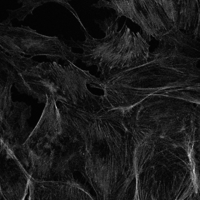

In [10]:
fnames = get_image_files(path_train_raw)
print(parent_label(fnames[0]))
Image.open(fnames[0]).to_thumb(200)

In [18]:
#| export
def get_gt(fn): return path_train_gt/f"{parent_label(fn)}"/"avg50.png"

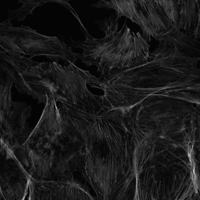

In [19]:
Image.open(get_gt(fnames[0])).to_thumb(200)

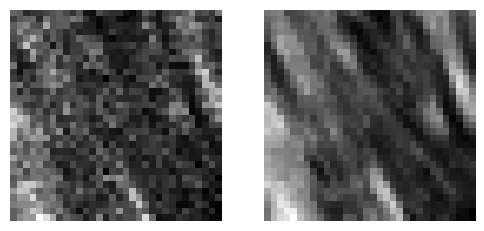

In [12]:
dblock = DataBlock(blocks    = (ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                   get_items = get_image_files, 
                   get_y = get_gt,
                   splitter  = RandomSplitter(valid_pct=0.2),
                   item_tfms = RandomCrop(32),
                   )
# dblock.summary(path_train_raw)
# dsets = dblock.datasets(path_train_raw)
# dsets.train[0]
dls = dblock.dataloaders(path_train_raw)
dls.show_batch(max_n=1, cmap='gray')

In [13]:
# from fastai.layers import *
ks = 3
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            ConvLayer(1, 12, ks=ks),            # [batch, 12, 16, 16]
            ConvLayer(12, 24, ks=ks),           # [batch, 24, 8, 8]
            ConvLayer(24, 48, ks=ks),           # [batch, 48, 4, 4]
        )
        self.decoder = nn.Sequential(
            ConvLayer(48, 24, ks=ks, transpose=True, padding=(ks-1)//2),  # [batch, 24, 8, 8]
            ConvLayer(24, 12, ks=ks, transpose=True, padding=(ks-1)//2),  # [batch, 12, 16, 16]
            ConvLayer(12, 1, ks=ks, transpose=True, padding=(ks-1)//2, act_cls=None),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return x - decoded

SuggestedLRs(valley=0.00363078061491251)

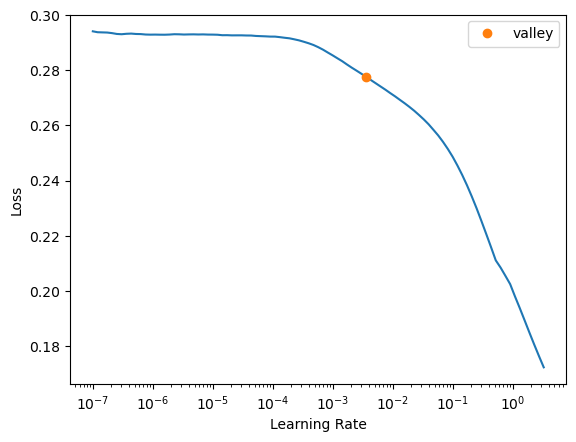

In [14]:
autoencoder = Autoencoder()
learn = Learner(dls, autoencoder, loss_func = F.mse_loss)
learn.lr_find()
# learn.model

In [15]:
learn.fit_one_cycle(20, lr_max = 1e-01)

epoch,train_loss,valid_loss,time
0,0.242263,0.217057,00:08
1,0.218135,0.215167,00:08
2,0.181392,0.103382,00:08
3,0.139135,0.034893,00:07
4,0.104895,0.067672,00:08
5,0.086412,0.898298,00:07
6,0.067680,0.386272,00:07
7,0.053014,0.006070,00:08
8,0.041790,0.005546,00:08
9,0.033191,0.004940,00:07


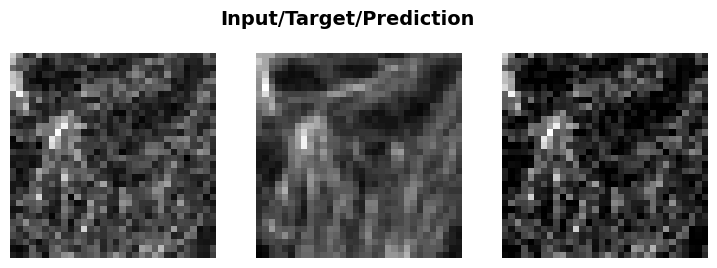

In [16]:
learn.show_results(max_n=1, cmap='gray')

In [17]:
#| hide
import nbdev; nbdev.nbdev_export()